# KNN Classifier using Wi-Fi data

<p>Jupyter Notebook which aims to explore the ML algorithm K-Nearest Neighbors as a Classifier algorithm using the Wi-Fi technologies moreover using the strength of the signal as a basis. </p>

## Imports
Imports of the libraries to be used throughout the experiments

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

## Load File and Structure Data Function
Function to load csv and structure data accordingly

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

## Initialize Training Data

In [3]:
def find_beacon_index():
    first_beacon_index = -1
    for ap in dataset.iloc[:,4:]:
        if ap.islower() == False:
            first_beacon_index = list(dataset).index(ap)
            break
    return first_beacon_index

In [4]:
dataset = load_file('../radiomapBluetoothWiFiclassifier.csv')
beacon_index = find_beacon_index()
X_train = dataset.iloc[:,4:beacon_index]
Y_train = dataset.iloc[:,3:4]
nan_filler = X_train.min().min()*1.010
X_train = X_train.replace(0, np.nan)
X_train = X_train.fillna(nan_filler)

## Access Points Graphical Display
Graphical display with the average strength signal transmitted by each access point

<BarContainer object of 15 artists>

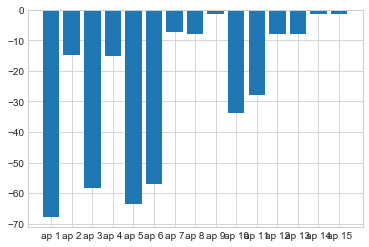

In [5]:
count_aps = {}
counter = 1
first_beacon_index = -1
for ap in X_train:
    mean_value = dataset[ap].mean()
    count_aps['ap ' + str(counter)] = mean_value
    counter = counter + 1
plt.bar(range(len(count_aps)),list(count_aps.values()),align='center',tick_label=list(count_aps.keys()))

## Number of Fingerprints per Reference Point Graphical Display
Graphical display of the number of fingerprints retrieved at each reference point

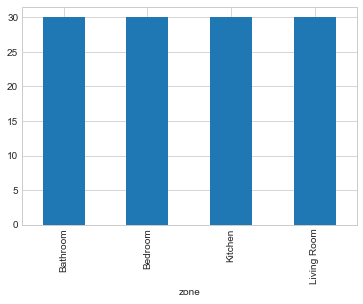

In [6]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

## Signal Strength Distribution Display
Graphical display of the distribution of the signal strength

### Wifi Signal Strength

Text(0, 0.5, 'Probability')

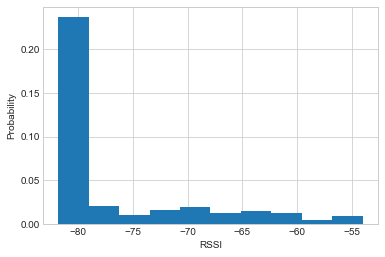

In [7]:
flatten_results = X_train.values.flatten().tolist()
flatten_results = list(filter((0).__ne__,flatten_results))
plt.hist(flatten_results,density=True)
plt.xlabel('RSSI')
plt.ylabel('Probability')

## Initialize KNN Parameters arrays
Initialization of the arrays with the different possible values for the parameters of KNN Classifier function

In [8]:
#Knn Configurable parameters arary
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
filters = ["Median","Mean","No Filter"]
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
weights = ["uniform","distance"]
default_data_scenario = Y_train.copy()
default_data_scenario_groups = default_data_scenario["zone"].map(str)
nan_filler = X_train.min().min()*1.010
X_train = X_train.fillna(nan_filler)

## Statistics Output Format
Structure of the statistical output of each call to the KNN Regression Function

In [9]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

## Configurable KNN Classifier Function 
Configurable function to aplpy the knn to a training set

In [10]:
def compute_KNN_with_Classifier(flag = 1,trainX_data = None,trainY_data = None,testX_data = None,testY_data = None,scaler = None,cross_validation = None,n_neighbors=4,
                                weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1):
    # Init the KNN Regressor Estimator
    knn_classifier_estimator = KNeighborsClassifier(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_classifier_estimator)
    else:
        main_estimator = knn_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data.values.ravel())
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data.values,testY_data.values.ravel(),cv = cross_validation,groups=default_data_scenario_groups)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    # Structure data to statistics
    statistics = pd.DataFrame(report).transpose()
    statistical_array = list()
    coord_cols = ['zone']
    predictions = pd.DataFrame(predict_test,columns=coord_cols)
    result = testY_data.join(predictions, rsuffix="_predicted")
    error = pd.DataFrame(np.where(predictions[coord_cols] != result[coord_cols],1,0), columns=["error"])
    result = pd.concat([result,error], axis = 1)
    if flag == 0:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(result)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

## Experiments

### 1st Experiment - Running KNN function with default parameters and testing data equal to training data

In [11]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
result = compute_KNN_with_Classifier(flag=0,trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

Confusion Matrix:
[[29  0  1  0]
 [ 0 30  0  0]
 [ 1  0 29  0]
 [ 2  0  0 28]]


precision    recall  f1-score     support
Bathroom       0.906250  0.966667  0.935484   30.000000
Bedroom        1.000000  1.000000  1.000000   30.000000
Kitchen        0.966667  0.966667  0.966667   30.000000
Living Room    1.000000  0.933333  0.965517   30.000000
accuracy       0.966667  0.966667  0.966667    0.966667
macro avg      0.968229  0.966667  0.966917  120.000000
weighted avg   0.968229  0.966667  0.966917  120.000000

zone zone_predicted  error
0     Kitchen        Kitchen      0
1     Kitchen        Kitchen      0
2     Kitchen        Kitchen      0
3     Kitchen        Kitchen      0
4     Kitchen        Kitchen      0
..        ...            ...    ...
115  Bathroom       Bathroom      0
116  Bathroom       Bathroom      0
117  Bathroom       Bathroom      0
118  Bathroom       Bathroom      0
119  Bathroom       Bathroom      0

[120 rows x 3 columns]

mae       mse      rmse  precision  accuracy  f1-score
0  0.033333  0.033333  0.182574   0.968006  0.966667  0.966881

### 2nd Experiment - Finding the best k parameter with Grid Search

In [12]:
def grid_search():
    knn_classifier_estimator = KNeighborsClassifier() #init knn regressor estimator
    k_range = list(range(1, 31))
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_classifier_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=10)
    #fit model to data
    estimator.fit(X_train.values,Y_train.values.ravel())
    print(estimator.best_params_)
    return estimator.best_params_['knn__n_neighbors']


In [13]:
best_knn = grid_search()

{'knn__n_neighbors': 3}


### 3rd Experiment - Graphical Display of k accuracy

In [14]:
def find_fit_k():
    k_range = list(range(1, 31))
    param_grid = {'knn__n_neighbors': k_range}
    knn_classifier_estimator = KNeighborsClassifier() #init knn regressor estimator
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_classifier_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=10)
    #fit model to data
    estimator.fit(X_train.values, Y_train.values.ravel())
    grid_mean_scores = estimator.cv_results_['mean_test_score']
    print('Max accuracy: ', max(grid_mean_scores))
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-validated accuracy')

Max accuracy:  0.9666666666666666


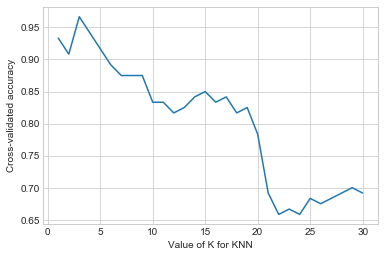

In [15]:
find_fit_k()

### 4th Experiment - Running the KNN function with default parameters and Hold-out Cross Validation

mae       mse      rmse  precision  accuracy  f1-score  test_size
0  0.083333  0.083333  0.288675   0.934524  0.916667  0.914626        0.1
1  0.125000  0.125000  0.353553   0.892857  0.875000  0.876855        0.2
3  0.125000  0.125000  0.353553   0.886039  0.875000  0.877243        0.4
5  0.125000  0.125000  0.353553   0.891881  0.875000  0.874543        0.6
4  0.133333  0.133333  0.365148   0.880952  0.866667  0.867761        0.5
2  0.166667  0.166667  0.408248   0.851190  0.833333  0.836935        0.3
6  0.261905  0.261905  0.511766   0.767594  0.738095  0.725222        0.7
7  0.354167  0.354167  0.595119   0.727601  0.645833  0.635283        0.8
8  0.555556  0.555556  0.745356   0.705058  0.444444  0.420007        0.9

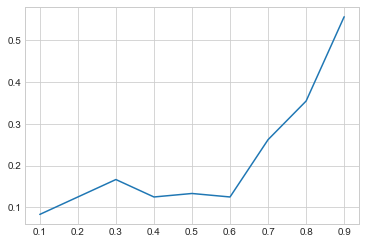

In [16]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
    X_train_split = X_train_split.reset_index(drop=True)
    X_test_split = X_test_split.reset_index(drop=True)
    Y_train_split = Y_train_split.reset_index(drop=True)
    Y_test_split = Y_test_split.reset_index(drop=True)
    result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae'],))
plt.plot(statistics['test_size'],statistics['mae'])

### 5th Experiment -  Running the KNN function with default parameters and Stratified K-Fold cross validation

mae       mse      rmse  precision  accuracy  f1-score  folds
8  0.058333  0.058333  0.241523   0.945376  0.941667  0.942396     10
6  0.066667  0.066667  0.258199   0.936852  0.933333  0.933969      8
7  0.066667  0.066667  0.258199   0.936852  0.933333  0.933969      9
5  0.108333  0.108333  0.329140   0.900245  0.891667  0.890954      7
4  0.141667  0.141667  0.376386   0.867674  0.858333  0.857567      6
3  0.158333  0.158333  0.397911   0.845759  0.841667  0.839866      5
2  0.183333  0.183333  0.428174   0.832123  0.816667  0.817501      4
0  0.208333  0.208333  0.456435   0.801586  0.791667  0.789973      2
1  0.291667  0.291667  0.540062   0.724863  0.708333  0.707108      3

Number of Folds:  10


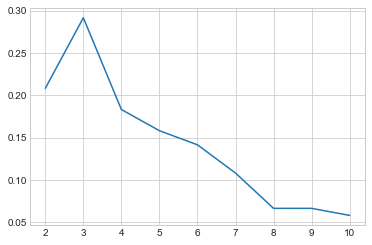

In [17]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
cross_validation_list = np.arange(2,11)
results = list()
for cv in cross_validation_list:
    result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

### 6th Experiment -  Running the KNN function with default parameters and Leave One Group Out cross validation

In [18]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(X_train,default_data_scenario_groups,groups=default_data_scenario_groups)
loo = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

mae  mse  rmse  precision  accuracy  f1-score
0  1.0  1.0   1.0        0.0       0.0       0.0

### 8th Experiment - Compare cross validation methods

mae       mse      rmse  precision  accuracy  f1-score  \
2  0.058333  0.058333  0.241523   0.945376  0.941667  0.942396   
1  0.555556  0.555556  0.745356   0.705058  0.444444  0.420007   
0  1.000000  1.000000  1.000000   0.000000  0.000000  0.000000   

              method  
2  Stratified K-Fold  
1            HoldOut  
0                LOO

Selected cross validation method:  Stratified K-Fold


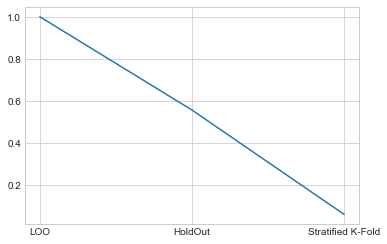

In [19]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method']
results = list()
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
X_train_split = X_train_split.reset_index(drop=True)
X_test_split = X_test_split.reset_index(drop=True)
y_train_split = y_train_split.reset_index(drop=True)
y_test_split = y_test_split.reset_index(drop=True)
holdout = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
loo.append('LOO')
results.append(loo)
holdout.append('HoldOut')
results.append(holdout)
skfold = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

### 9th Experiment - Running the KNN function with the different weights

mae       mse      rmse  precision  accuracy  f1-score   weights
1  0.033333  0.033333  0.182574   0.967588  0.966667  0.966897  distance
0  0.058333  0.058333  0.241523   0.945376  0.941667  0.942396   uniform

Selected weight:  distance


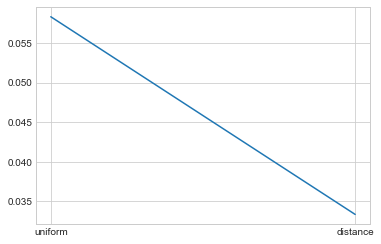

In [20]:
statistical_cols =['mae','mse','rmse','precision','accuracy','f1-score','weights']
results = list()
for weight in weights:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                           weights = weight)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,weights=weight)
    else:
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                           weights = weight)
    result.append(weight)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

### 10th Experiment - Running the KNN function with the different preprocessing methods

mae       mse      rmse  precision  accuracy  f1-score  \
1  0.033333  0.033333  0.182574   0.967588  0.966667  0.966897   
2  0.033333  0.033333  0.182574   0.967760  0.966667  0.966885   
3  0.033333  0.033333  0.182574   0.967760  0.966667  0.966885   
0  0.058333  0.058333  0.241523   0.945376  0.941667  0.942396   

    preprocessing                                  preprocessingFunc  
1    MinMaxScaler      MinMaxScaler(copy=True, feature_range=(0, 1))  
2    MaxAbsScaler                            MaxAbsScaler(copy=True)  
3            None                                               None  
0  StandardScaler  StandardScaler(copy=True, with_mean=True, with...

Selected Preprocessing:  MinMaxScaler


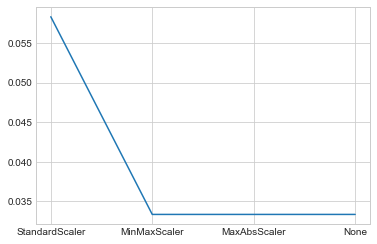

In [21]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc']
results = list()
for preprocess in scaler:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = selected_fold)
    else:
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocess)
    if(preprocess is None):
        regex = 'None'
    else:
        regex = re.search('(\w+)\(',str(preprocess)).group(1)
    result.append(regex)
    result.append(preprocess)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['mae'])['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### 11th Experiment - Running the KNN function with the different algorithms

mae       mse      rmse  precision  accuracy  f1-score algorithms
1  0.058333  0.058333  0.241523   0.945376  0.941667  0.942396    kd_tree
3  0.058333  0.058333  0.241523   0.945376  0.941667  0.942396       auto
0  0.075000  0.075000  0.273861   0.927614  0.925000  0.924963      brute
2  0.075000  0.075000  0.273861   0.927614  0.925000  0.924963  ball_tree

Selected Algorithm:  kd_tree


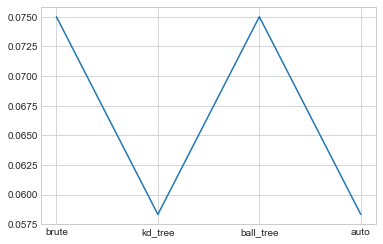

In [22]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','algorithms']
results = list()
for algorithm in algorithms:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            algorithm = algorithm)
    else:
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            algorithm = algorithm)
    result.append(algorithm)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['algorithms'],statistics['mae'])
selected_algorithm = statistics.sort_values(by=['mae'])['algorithms'].head(1).values[0]
print("Selected Algorithm: ",selected_algorithm)

### 12th Experiment - Running the KNN function with the different distance metrics

mae       mse      rmse  precision  accuracy  f1-score    distance
1  0.041667  0.041667  0.204124   0.960133  0.958333  0.958663   manhattan
0  0.058333  0.058333  0.241523   0.945376  0.941667  0.942396   euclidean
3  0.058333  0.058333  0.241523   0.942974  0.941667  0.941754  braycurtis
2  0.075000  0.075000  0.273861   0.927687  0.925000  0.925381    canberra

Selected Distance Metric:  manhattan


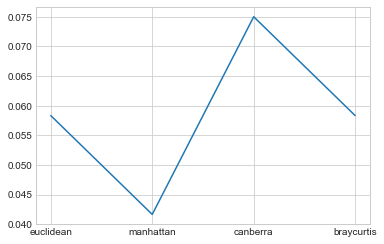

In [23]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','distance']
results = list()
for distance in distance_metris:
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            metric = distance)
    else:
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            metric = distance)
    result.append(distance)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['distance'],statistics['mae'])
selected_distance_metric = statistics.sort_values(by=['mae'])['distance'].head(1).values[0]
print("Selected Distance Metric: ",selected_distance_metric)

### 13th Experiment: Run with every configurable parameters and let the program decide the best parameters
Match these with the previously settled.

In [24]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','distance','preprocessing','weights']
results = list()
k_range = range(1, 31)
for distance in distance_metris:
    for preprocessing in scaler:
        for weight in weights:
            if selected_method == 'LOO':
                cv = LeaveOneGroupOut()
                splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
                result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                                    metric = distance,weights=weight)  
            elif selected_method =='Stratified K-Fold':
                result = compute_KNN_with_Classifier(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = selected_fold,
                                                    metric = distance,weights=weight)
            else:
                result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocessing,
                                                    metric = distance,weights=weight)
            result.append(distance)
            if(preprocessing is None):
                regex = 'None'
            else:
                regex = re.search('(\w+)\(',str(preprocessing)).group(1)
            result.append(regex)
            result.append(weight)
            results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

mae       mse      rmse  precision  accuracy  f1-score    distance  \
10  0.033333  0.033333  0.182574   0.967588  0.966667  0.966897   manhattan   
1   0.033333  0.033333  0.182574   0.967588  0.966667  0.966897   euclidean   
2   0.033333  0.033333  0.182574   0.967588  0.966667  0.966897   euclidean   
25  0.033333  0.033333  0.182574   0.967588  0.966667  0.966897  braycurtis   
4   0.033333  0.033333  0.182574   0.967760  0.966667  0.966885   euclidean   
6   0.033333  0.033333  0.182574   0.967760  0.966667  0.966885   euclidean   
27  0.033333  0.033333  0.182574   0.967588  0.966667  0.966897  braycurtis   
30  0.041667  0.041667  0.204124   0.959673  0.958333  0.958673  braycurtis   
14  0.041667  0.041667  0.204124   0.959673  0.958333  0.958673   manhattan   
12  0.041667  0.041667  0.204124   0.959673  0.958333  0.958673   manhattan   
28  0.041667  0.041667  0.204124   0.959673  0.958333  0.958673  braycurtis   
20  0.041667  0.041667  0.204124   0.959673  0.958333  0.958673    canberra   
8   0.041667  0.041667  0.204124   0.960133  0.958333  0.958663   manhattan   
7   0.041667  0.041667  0.204124   0.960421  0.958333  0.958631   euclidean   
5   0.041667  0.041667  0.204124   0.960421  0.958333  0.958631   euclidean   
3   0.041667  0.041667  0.204124   0.959673  0.958333  0.958673   euclidean   
22  0.041667  0.041667  0.204124   0.959673  0.958333  0.958673    canberra   
29  0.050000  0.050000  0.223607   0.952105  0.950000  0.950427  braycurtis   
26  0.050000  0.050000  0.223607   0.951615  0.950000  0.949685  braycurtis   
23  0.050000  0.050000  0.223607   0.952105  0.950000  0.950427    canberra   
15  0.050000  0.050000  0.223607   0.952105  0.950000  0.950427   manhattan   
31  0.050000  0.050000  0.223607   0.952105  0.950000  0.950427  braycurtis   
13  0.050000  0.050000  0.223607   0.952105  0.950000  0.950427   manhattan   
11  0.050000  0.050000  0.223607   0.952031  0.950000  0.950447   manhattan   
9   0.050000  0.050000  0.223607   0.952031  0.950000  0.950447   manhattan   
21  0.050000  0.050000  0.223607   0.952105  0.950000  0.950427    canberra   
24  0.058333  0.058333  0.241523   0.942974  0.941667  0.941754  braycurtis   
0   0.058333  0.058333  0.241523   0.945376  0.941667  0.942396   euclidean   
17  0.066667  0.066667  0.258199   0.935119  0.933333  0.933778    canberra   
19  0.075000  0.075000  0.273861   0.925716  0.925000  0.924821    canberra   
16  0.075000  0.075000  0.273861   0.927687  0.925000  0.925381    canberra   
18  0.108333  0.108333  0.329140   0.899773  0.891667  0.893448    canberra   

     preprocessing   weights  
10    MinMaxScaler   uniform  
1   StandardScaler  distance  
2     MinMaxScaler   uniform  
25  StandardScaler  distance  
4     MaxAbsScaler   uniform  
6             None   uniform  
27    MinMaxScaler  distance  
30            None   uniform  
14            None   uniform  
12    MaxAbsScaler   uniform  
28    MaxAbsScaler   uniform  
20    MaxAbsScaler   uniform  
8   StandardScaler   uniform  
7             None  distance  
5     MaxAbsScaler  distance  
3     MinMaxScaler  distance  
22            None   uniform  
29    MaxAbsScaler  distance  
26    MinMaxScaler   uniform  
23            None  distance  
15            None  distance  
31            None  distance  
13    MaxAbsScaler  distance  
11    MinMaxScaler  distance  
9   StandardScaler  distance  
21    MaxAbsScaler  distance  
24  StandardScaler   uniform  
0   StandardScaler   uniform  
17  StandardScaler  distance  
19    MinMaxScaler  distance  
16  StandardScaler   uniform  
18    MinMaxScaler   uniform

### 14th Experiment: Running the KNN function with data filtered 

In [25]:
def apply_filter():
    statistical_cols =  ['mae','mse','rmse','precision','accuracy','f1-score','filter']
    results = list()
    for filterelement in filters:
        if filterelement == 'Median':
            result = apply_median_filter()
        elif filterelement == 'Mean':
            result = apply_mean_filter()
        else:
            result = compute_KNN_with_Classifier(trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),
                                                 metric = selected_distance_metric,algorithm=selected_algorithm,cross_validation = selected_fold,
                                                 weights=selected_weight)
            result.append('No Filter')
        results.append(result)
    statistics = pd.DataFrame(columns=statistical_cols,data=results)
    display(statistics.sort_values(by=['mae']))
    plt.plot(statistics['filter'],statistics['mae'])
    selected_filter = statistics.sort_values(by=['mae'])['filter'].head(1).values[0]
    print("Selected Filter: ",selected_filter)
    return selected_filter
            

def apply_median_filter():
    medians = list()
    aps = ['zone']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        medians_list = [rp]
        for ap in X_train:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,1:]
    y_train = median_pd.iloc[:,0:1]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    result = compute_KNN_with_Classifier(trainX_data=x_train,trainY_data=y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),
                                         metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
    result.append('Median')
    return result

def apply_mean_filter(): 
    means = list()
    aps = ['zone']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        zone = rp
        means_list = [zone]
        for ap in X_train:
            mean = access_points[ap].mean()
            means_list.append(mean)
        means.append(means_list)
    mean_pd = pd.DataFrame(means,columns = aps)
    x_train = mean_pd.iloc[:,1:]
    y_train = mean_pd.iloc[:,0:1]
    nan_filler = X_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    result = compute_KNN_with_Classifier(trainX_data=x_train,trainY_data=y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),
                                         metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
    result.append('Mean')
    return result

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mae   mse      rmse  precision  accuracy  f1-score     filter
2  0.05  0.05  0.223607   0.952031      0.95  0.950447  No Filter
0  0.50  0.50  0.707107   0.291837      0.50  0.360714     Median
1  0.75  0.75  0.866025   0.089286      0.25  0.121429       Mean

Selected Filter:  No Filter


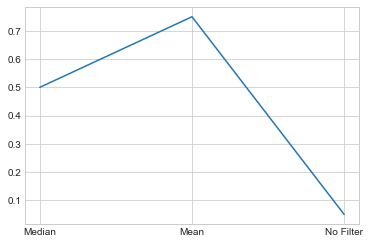

In [26]:
selected_filter = apply_filter()

# Results Analysis and Conclusion
Analysis of the outcomes of the different experiments and final conclusions.

In [27]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance','Filtering']
conclusion_list = [best_knn,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance_metric,selected_filter]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)
statistical_cols_csv = conclusion_cols
statistical_cols_csv.append('Experimentation')
result_csv = conclusion_list
result_csv.append('KNN Classifier Wifi')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../parameters_results.csv',mode='a',index=False,header=False)

K Parameter   Cross Validation    Weight Preprocessing Algorithm  \
0            3  Stratified K-Fold  distance  MinMaxScaler   kd_tree   

    Distance  Filtering  
0  manhattan  No Filter

### Best Result

In [28]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
if selected_method == 'LOO':
    cv = LeaveOneGroupOut()
    splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
    result = compute_KNN_with_Classifier(flag=0,n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = splited,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)  
elif selected_method =='Stratified K-Fold':
    result = compute_KNN_with_Classifier(flag=0,n_neighbors=best_knn,testX_data=X_train,testY_data=Y_train,scaler=selected_preprocesssing_func,cross_validation = selected_fold,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)  
else:
    result = compute_KNN_with_Classifier(flag=0,trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=selected_preprocesssing_func,
                            metric = selected_distance_metric,weights=selected_weight,algorithm=selected_algorithm)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
statistical_cols_csv = ['mae','mse','rmse']
statistical_cols_csv.append('Experimentation')
result_csv = result[0:3]
result_csv.append('KNN Classifier Wifi')
results_csv = [result_csv]
results_df = pd.DataFrame(columns=statistical_cols_csv,data=results_csv)
results_df.to_csv('../tests_results.csv',mode='a',index=False,header=False)

Confusion Matrix:
[[29  0  1  0]
 [ 0 28  2  0]
 [ 2  0 28  0]
 [ 1  0  0 29]]


precision    recall  f1-score  support
Bathroom       0.906250  0.966667  0.935484    30.00
Bedroom        1.000000  0.933333  0.965517    30.00
Kitchen        0.903226  0.933333  0.918033    30.00
Living Room    1.000000  0.966667  0.983051    30.00
accuracy       0.950000  0.950000  0.950000     0.95
macro avg      0.952369  0.950000  0.950521   120.00
weighted avg   0.952369  0.950000  0.950521   120.00

zone zone_predicted  error
0     Kitchen        Kitchen      0
1     Kitchen        Kitchen      0
2     Kitchen        Kitchen      0
3     Kitchen        Kitchen      0
4     Kitchen        Kitchen      0
..        ...            ...    ...
115  Bathroom       Bathroom      0
116  Bathroom       Bathroom      0
117  Bathroom       Bathroom      0
118  Bathroom       Bathroom      0
119  Bathroom       Bathroom      0

[120 rows x 3 columns]

mae   mse      rmse  precision  accuracy  f1-score
0  0.05  0.05  0.223607   0.952031      0.95  0.950447